# Analysis of pretrained CNN

In [ ]:
# Note: Load model and train again to track training process. (should work, tested in console)

In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


We now load the pretrained model with the hyperparameters found by bayesian optimization.

In [10]:
model = tf.keras.models.load_model('../trained-models/fer_best.keras')

In [11]:
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_conv0 (Conv2D)            │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_conv1 (Conv2D)            │ (None, 22, 22, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 1024)           │     5,309,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,411,031 (74.05 MB)

 Trainable params: 6,470,343 (24.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,940,688 (49.36 MB)

## Training
In order to train the model we will load the data and then augment it.

In [78]:
# parameters
DATA = '../CK+48'
IMG_WIDTH = 48
IMG_HEIGHT = 48
EPOCHS = 50
TEST_SIZE = 0.4

# load the data
def dir_id(directory: str) -> int:
    return {'anger': 0,
            'contempt': 1,
            'disgust': 2,
            'fear': 3,
            'happy': 4,
            'sadness': 5,
            'surprise': 6
            }[directory]


def preprocess_image(img_path: str, width: int, height: int) -> np.ndarray:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (width, height))
    img = np.array(img)
    img = img.reshape((1,) + img.shape)

    return img


def load_data(data: str, width: int, height: int) -> (np.ndarray, np.ndarray):
    """
    Assuming all pictures are structured in subdirectories names as the corresponding expression
    :param data: str containing the root directory of the data
    :param width: goal width of image
    :param height: goal height of image
    :return: tuple (evidence, labels)
    """
    evidence = []
    labels = []

    subdirectories = [directory for directory in os.listdir(data) if directory[0] != '.']

    for subdirectory in subdirectories:
        if os.path.isdir(os.path.join(data, subdirectory)):
            for img_path in os.listdir(os.path.join(data, subdirectory)):
                img = preprocess_image(os.path.join(data, subdirectory, img_path), width, height)
                evidence.append(img)
                labels.append(dir_id(subdirectory))

    return evidence, labels


evidence, labels = load_data(DATA, IMG_WIDTH, IMG_HEIGHT)

labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(np.array(evidence), np.array(labels), test_size=TEST_SIZE)

### Data augmentation

In [16]:
# train and test data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    brightness_range=[0.8, 1.2],
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)


# Reshape images for compatibility with the augmentation
x_train = x_train.reshape((-1, IMG_WIDTH, IMG_HEIGHT, 1))
x_test = x_test.reshape((-1, IMG_WIDTH, IMG_HEIGHT, 1))

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32,
)

test_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
)

In [26]:
# train the model and store the training process in history
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9812 - loss: 0.0554 - val_accuracy: 0.9797 - val_loss: 0.0558
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9884 - loss: 0.0385 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9878 - loss: 0.0448 - val_accuracy: 0.9715 - val_loss: 0.0467
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9876 - loss: 0.0466 - val_accuracy: 0.9959 - val_loss: 0.0137
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9965 - loss: 0.0129 - val_accuracy: 0.9919 - val_loss: 0.0185
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9948 - loss: 0.0185 - val_accuracy: 0.9878 - val_loss: 0.0322
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9715 - loss: 0.0865 - val_accuracy: 0.9959 - v

### Analyse the training process
Now we plot how the loss and accuracy developed during training

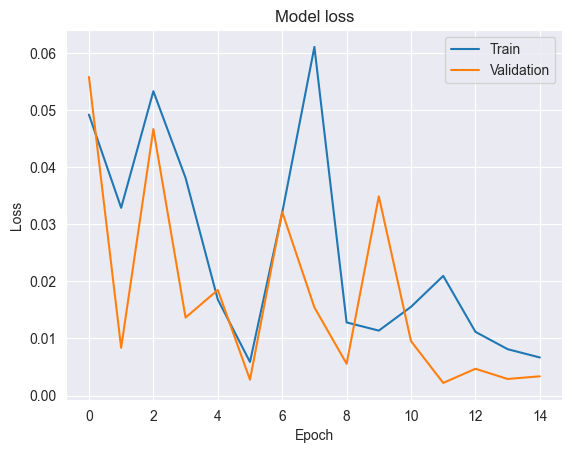

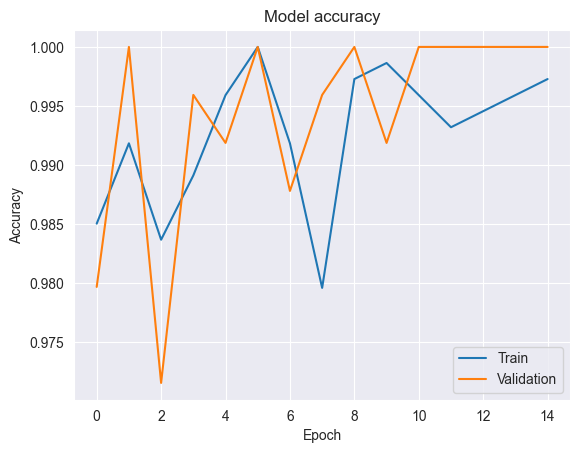

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

When using the above pretrained model it seems like the accuracy and loss are oscillating around randomly in a pretty well performing area. This might be since the data set does not allow us to learn enough features to be sure without overfitting or due to some images that fall out of the scheme of the expression of the others. Nevertheless, I have put two images of the training progress of accuracy and loss of a model that is not adjusted this well a priori into this directory.

### Confusion matrix
The confusion matrix informs presents in a very nice visualization which categories get mixed up with which other category most likely by the AI.

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [83]:
# reload model to prevent over-fitting and to good results in the following tests
model = tf.keras.models.load_model('../trained-models/fer_best.keras')

In [79]:
# since we do not use the data augmentation at this point, we need to transpose x_test to directly use the model on it
print(x_test.shape)
x_test = np.transpose(x_test, (0, 2, 3, 1))
print(x_test.shape)

(393, 1, 48, 48)
(393, 48, 48, 1)


In [84]:
results = model.predict(x_test)

true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(results, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix by dividing each element by the total number of samples in the corresponding true class
class_counts = np.sum(conf_matrix, axis=1)

normalized_cm = conf_matrix / class_counts[:, np.newaxis]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


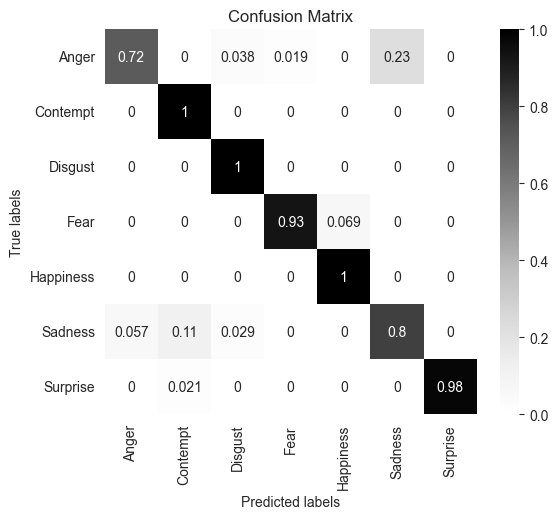

In [85]:
labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
plt.figure(figsize=(6,5))
sns.heatmap(normalized_cm, annot=True, cmap='Grays', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Scores
We will now evaluate the precision, recall, F1 score and Cohen's kappa which is a score that also considers the expectation that by chance the prediction and the actual value are equal. 

In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1_score = f1_score(true_labels, predicted_labels, average='weighted')
cohen_kappa = cohen_kappa_score(true_labels, predicted_labels)

In [90]:
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)
print("Cohen kappa: ", cohen_kappa)

Precision:  0.9397855325336242
Recall:  0.9338422391857506
F1 score:  0.9334129367075152
Cohen kappa:  0.9192125237191651
